# Imports and Setup

In [1]:
import os
import gc
import joblib
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import segmentation_models_pytorch as smp
from PIL import Image
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from collections import defaultdict

import mlflow
from mlflow.tracking import MlflowClient
import optuna
import optuna.visualization as viz
from optuna.integration import PyTorchLightningPruningCallback
from pytorch_lightning.loggers import MLFlowLogger

# Set random seed for reproducibility
pl.seed_everything(42, workers=True)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Seed set to 42


Using device: cuda


# Classes and Definitions

In [2]:
class DepthDistillationDataset(Dataset):
    def __init__(self, img_dir, depth_dir, is_train=False, prob=None):
        """
        Args:
            img_dir: Directory with input images
            depth_dir: Directory with teacher depth maps (.npy files)
            is_train: Whether this is training dataset (for augmentation)
            prob: Dictionary with augmentation probabilities 
                  {'horizontal_flip': float, 'color_jitter': float}
        """
        self.img_dir = img_dir
        self.depth_dir = depth_dir
        self.is_train = is_train
        self.prob = prob if prob is not None else {'horizontal_flip': 0.5, 'color_jitter': 0.5}
        
        # Get list of images
        self.images = sorted([f for f in os.listdir(img_dir) if f.endswith('.png')])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        
        # Load image
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        # Load teacher predictions
        depth_path = os.path.join(self.depth_dir, img_name.replace('.png', '.npy'))
        teacher_depth = np.load(depth_path)
        
        # Apply synchronized augmentations if training
        if self.is_train:
            # Random horizontal flip
            if torch.rand(1).item() < self.prob['horizontal_flip']:
                image = TF.hflip(image)
                teacher_depth = np.fliplr(teacher_depth).copy()
            
            # Color jitter (only on image)
            if torch.rand(1).item() < self.prob['color_jitter']:
                color_jitter = T.ColorJitter(brightness=0.25, contrast=0.25)
                image = color_jitter(image)
        
        # Convert to tensors
        image = TF.to_tensor(image)
        image = TF.normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
        teacher_depth = torch.from_numpy(teacher_depth).float()
        
        return image, teacher_depth

In [3]:
class DataModule(pl.LightningDataModule):
    def __init__(self, 
                 train_img_dir, train_depth_dir,
                 val_img_dir, val_depth_dir,
                 test_img_dir, test_depth_dir,
                 batch_size=4, 
                 num_workers=2,
                 prob=None):
        """
        Args:
            train_img_dir, train_depth_dir: Training data directories
            val_img_dir, val_depth_dir: Validation data directories
            test_img_dir, test_depth_dir: Test data directories
            batch_size: Batch size for dataloaders
            num_workers: Number of workers for dataloaders
            prob: Dictionary with augmentation probabilities
        """
        super().__init__()
        self.train_img_dir = train_img_dir
        self.train_depth_dir = train_depth_dir
        self.val_img_dir = val_img_dir
        self.val_depth_dir = val_depth_dir
        self.test_img_dir = test_img_dir
        self.test_depth_dir = test_depth_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.prob = prob if prob is not None else {'horizontal_flip': 0.5, 'color_jitter': 0.5}
        
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train_dataset = DepthDistillationDataset(
                img_dir=self.train_img_dir,
                depth_dir=self.train_depth_dir,
                is_train=True,
                prob=self.prob
            )
            self.val_dataset = DepthDistillationDataset(
                img_dir=self.val_img_dir,
                depth_dir=self.val_depth_dir,
                is_train=False
            )
        
        if stage == 'test' or stage is None:
            self.test_dataset = DepthDistillationDataset(
                img_dir=self.test_img_dir,
                depth_dir=self.test_depth_dir,
                is_train=False
            )
    
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False
        )

In [4]:
class DepthDistillationLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse_loss = nn.MSELoss()
        
    def forward(self, student_pred, teacher_depth):
        """
        For depth prediction, we use:
        - Hard loss: Direct MSE on depth values
        
        Args:
            student_pred: Student model predictions [B, 1, H, W]
            teacher_depth: Teacher depth maps [B, H, W]
        """
        # Ensure correct shapes
        if student_pred.dim() == 4:
            student_pred = student_pred.squeeze(1)  # [B, H, W]
        
        # Hard loss: Direct MSE with teacher depth
        hard_loss = self.mse_loss(student_pred, teacher_depth)
        
        return hard_loss

In [5]:
class DepthDistillationModule(pl.LightningModule):
    def __init__(self, student_model, lr=3e-4, weight_decay=0.0):
        super().__init__()
        self.student = student_model
        self.lr = lr
        self.weight_decay = weight_decay
        
        self.criterion = DepthDistillationLoss()
        
        # Save hyperparameters
        self.save_hyperparameters(ignore=['student_model'])
    
    def forward(self, x):
        """Forward pass through student model"""
        return self.student(x)
    
    def training_step(self, batch, batch_idx):
        images, teacher_depth = batch
        
        # Get student predictions
        student_pred = self(images)
        
        # Calculate losses
        hard_loss = self.criterion(
            student_pred, teacher_depth
        )
        
        self.log('train_hard_loss', hard_loss, on_step=False, on_epoch=True, sync_dist=True)
        
        return hard_loss
    
    def validation_step(self, batch, batch_idx):
        images, teacher_depth = batch
        
        # Get student predictions
        student_pred = self(images)
        
        # Calculate losses
        hard_loss = self.criterion(
            student_pred, teacher_depth
        )
        
        self.log('val_hard_loss', hard_loss, on_step=False, on_epoch=True, sync_dist=True)
        
        return hard_loss
    
    def test_step(self, batch, batch_idx):
        """Test step for final evaluation"""
        images, teacher_depth = batch
        
        # Get student predictions
        student_pred = self(images)
        
        # Calculate losses
        hard_loss = self.criterion(
            student_pred, teacher_depth
        )
        
        self.log('test_hard_loss', hard_loss, on_step=False, on_epoch=True, sync_dist=True)
        
        return hard_loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )
        
        # Learning rate scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=10
        )
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_hard_loss'
            }
        }

# Dataset Verification

In [6]:
# Define your paths
TRAIN_IMG_DIR = '../CamVid/train/'
TRAIN_DEPTH_DIR = '../CamVid/train_labels/train_depths/'
VAL_IMG_DIR = '../CamVid/val/'
VAL_DEPTH_DIR = '../CamVid/val_labels/val_depths/'
TEST_IMG_DIR = '../CamVid/test/'
TEST_DEPTH_DIR = '../CamVid/test_labels/test_depths/'

# Define augmentation probabilities
prob = {
    'horizontal_flip': 0.5,
    'color_jitter': 0.3
}

# Create DataModule
data_module = DataModule(
    train_img_dir=TRAIN_IMG_DIR,
    train_depth_dir=TRAIN_DEPTH_DIR,
    val_img_dir=VAL_IMG_DIR,
    val_depth_dir=VAL_DEPTH_DIR,
    test_img_dir=TEST_IMG_DIR,
    test_depth_dir=TEST_DEPTH_DIR,
    batch_size=4,
    num_workers=2,
    prob=prob
)

# Test it
data_module.setup()
print(f"Training samples: {len(data_module.train_dataset)}")
print(f"Validation samples: {len(data_module.val_dataset)}")
print(f"Test samples: {len(data_module.test_dataset)}")

sample_img, sample_depth = data_module.train_dataset[0]
print(f"\nImage Size: {sample_img.shape}")
print(f"Depth Map Size: {sample_depth.shape}")

Training samples: 369
Validation samples: 100
Test samples: 232

Image Size: torch.Size([3, 720, 960])
Depth Map Size: torch.Size([720, 960])


All shapes are 720x960, so the dataset is correctly loading the samples

# MLFlow and Optuna Setup

## MLFlow URI and Experiment Name

In [7]:
# Set tracking URI
mlflow.set_tracking_uri("mlruns")

# Set experiment name
EXPERIMENT_NAME = "depth_distillation_optimization_only_hard"
mlflow.set_experiment(EXPERIMENT_NAME)

print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")
print(f"Experiment: {EXPERIMENT_NAME}")

MLflow tracking URI: mlruns
Experiment: depth_distillation_optimization_only_hard


/home/alumno/Desktop/datos/Computer Vision/depth-anything-3/.venv/lib/python3.11/site-packages/mlflow/tracking/_tracking_service/utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)


## Optuna Objective Function

In [8]:
def objective(trial):
    """
    Optuna objective function for hyperparameter optimization.
    Trains depth distillation model and logs to MLflow.
    """
    
    # Suggest hyperparameters
    params = {
        
        # Training parameters
        'batch_size': trial.suggest_categorical('batch_size', [16, 24, 32]),
        'learning_rate': trial.suggest_float('learning_rate', 5e-5, 1e-3),
        'num_epochs': trial.suggest_int('num_epochs', 50, 150),
        
        # Augmentation probabilities
        'prob_horizontal_flip': trial.suggest_float('prob_horizontal_flip', 0.0, 0.7),
        'prob_color_jitter': trial.suggest_float('prob_color_jitter', 0.0, 0.7),
        
        # Optimizer parameters
        'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-3),
        
        # Fixed parameters
        'encoder_name': 'resnet18',
        'encoder_weights': 'imagenet',
        'num_workers': 2,
        'gradient_clip_val': 1.0,
    }
    
    # Start MLflow run (nested under parent run)
    with mlflow.start_run(nested=True, run_name=f"trial_{trial.number}"):
        
        # Log all hyperparameters
        mlflow.log_params(params)
        mlflow.log_param("trial_number", trial.number)
        
        # Create augmentation probabilities dict
        prob = {
            'horizontal_flip': params['prob_horizontal_flip'],
            'color_jitter': params['prob_color_jitter']
        }
        
        # Create data module
        data_module = DataModule(
            train_img_dir=TRAIN_IMG_DIR,
            train_depth_dir=TRAIN_DEPTH_DIR,
            val_img_dir=VAL_IMG_DIR,
            val_depth_dir=VAL_DEPTH_DIR,
            test_img_dir=TEST_IMG_DIR,
            test_depth_dir=TEST_DEPTH_DIR,
            batch_size=params['batch_size'],
            num_workers=params['num_workers'],
            prob=prob
        )
        
        # Create student model
        student = smp.Unet(
            encoder_name=params['encoder_name'],
            encoder_weights=params['encoder_weights'],
            in_channels=3,
            classes=1,
            activation=None
        )
        
        num_params = sum(p.numel() for p in student.parameters())
        mlflow.log_param("model_parameters", num_params)
        
        # Create Lightning module
        lightning_module = DepthDistillationModule(
            student_model=student,
            lr=params['learning_rate'],
            weight_decay=params['weight_decay']
        )
        
        # Setup MLflow logger for this trial
        mlflow_logger = MLFlowLogger(
            experiment_name=EXPERIMENT_NAME,
            run_id=mlflow.active_run().info.run_id
        )
        
        # Setup callbacks
        checkpoint_callback = ModelCheckpoint(
            monitor='val_hard_loss',
            mode='min',
            filename=f'trial_{trial.number}_best',
            save_top_k=1,
            verbose=False
        )
        
        early_stopping = EarlyStopping(
            monitor='val_hard_loss',
            patience=15,
            mode='min',
            verbose=False
        )
        
        # Optuna pruning callback
        pruning_callback = PyTorchLightningPruningCallback(trial, monitor="val_hard_loss")
        
        # Create trainer
        trainer = pl.Trainer(
            max_epochs=params['num_epochs'],
            logger=mlflow_logger,
            callbacks=[checkpoint_callback, early_stopping, pruning_callback],
            accelerator='gpu' if torch.cuda.is_available() else 'cpu',
            devices=1,
            gradient_clip_val=params['gradient_clip_val'],
            log_every_n_steps=10,
            enable_progress_bar=False,
            enable_model_summary=False
        )
        
        # Train the model
        try:
            trainer.fit(lightning_module, data_module)
            
            # FIXED: Get best validation loss properly with proper error handling
            if checkpoint_callback.best_model_score is not None:
                best_val_loss = float(checkpoint_callback.best_model_score)
            else:
                # Fallback: get from logged metrics
                best_val_loss = float(trainer.callback_metrics.get('val_hard_loss', float('inf')))
            
            # Log best metrics
            mlflow.log_metric("best_val_hard_loss", best_val_loss)
            mlflow.log_metric("epochs_trained", trainer.current_epoch)
            
            # Evaluate on test set
            test_results = trainer.test(
                lightning_module, 
                data_module, 
                ckpt_path=checkpoint_callback.best_model_path
            )
            
            if test_results:
                test_loss = test_results[0].get('test_hard_loss', None)
                if test_loss:
                    mlflow.log_metric("test_hard_loss", test_loss)
            
            # Log model artifact
            mlflow.pytorch.log_model(student, "model")
            
            # Log checkpoint (only if path exists)
            if checkpoint_callback.best_model_path:
                mlflow.log_artifact(checkpoint_callback.best_model_path, "checkpoints")
            
            print(f"Trial {trial.number}: val_hard_loss={best_val_loss:.4f}, "
                  f"epochs={trainer.current_epoch}")
            
            return best_val_loss
            
        except optuna.TrialPruned:
            print(f"Trial {trial.number} pruned")
            raise
        except Exception as e:
            print(f"Trial {trial.number} failed: {e}")
            import traceback
            traceback.print_exc()  # Print full traceback for debugging
            mlflow.log_param("status", "failed")
            mlflow.log_param("error", str(e))
            return float('inf')
        finally:
            # CRITICAL: Clean up resources after each trial
            print(f"Cleaning up Trial {trial.number}...")
            
            # Delete objects
            if 'trainer' in locals():
                del trainer
            if 'lightning_module' in locals():
                del lightning_module
            if 'student' in locals():
                del student
            if 'data_module' in locals():
                del data_module
            
            # Force garbage collection
            gc.collect()
            
            # Clear CUDA cache
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                torch.cuda.synchronize()
            
            print(f"Trial {trial.number} cleanup complete")

# Train Models -> Launch Optuna Study

In [ ]:
N_TRIALS = 75

# Safety: end any active runs before starting
mlflow.end_run()

# Set random seed for reproducibility
pl.seed_everything(42, workers=True)

# Create parent MLflow run
with mlflow.start_run(run_name="optuna_depth_distillation_only_hard") as parent_run:
    
    # Log study configuration
    mlflow.log_param("optimization_metric", "val_hard_loss")
    mlflow.log_param("n_trials", N_TRIALS)
    mlflow.log_param("model_type", "Depth_Distillation_UNet")
    mlflow.log_param("dataset", "CamVid")
    
    # Create Optuna study
    study = optuna.create_study(
        study_name="depth_distillation_optimization_only_hard",
        direction="minimize",
        sampler=optuna.samplers.TPESampler(seed=42),
        pruner=optuna.pruners.MedianPruner(n_startup_trials=15, n_warmup_steps=25),
        storage="sqlite:///optuna_study_only_hard.db",  # Persist to database
        load_if_exists=True  # Resume if interrupted
    )
    
    # Run optimization
    print("Starting Optuna optimization...")
    study.optimize(
        objective,
        n_trials=N_TRIALS,
        show_progress_bar=True
    )
    
    # Log best trial information
    best_trial = study.best_trial
    mlflow.log_params({f"best_{k}": v for k, v in best_trial.params.items()})
    mlflow.log_metric("best_val_hard_loss", best_trial.value)
    
    print(f"\n{'='*60}")
    print("Optimization Complete!")
    print(f"{'='*60}")
    print(f"Best trial number: {best_trial.number}")
    print(f"Best validation loss: {best_trial.value:.4f}")
    print(f"Best hyperparameters:")
    for key, value in best_trial.params.items():
        print(f"  {key}: {value}")
    
    # Generate and log optimization visualizations
    print("\nGenerating optimization visualizations...")
    
    try:
        # Create plots directory
        os.makedirs("plots", exist_ok=True)
        
        # Plot optimization history
        fig1 = viz.plot_optimization_history(study)
        fig1.write_html("plots/optimization_history.html")
        mlflow.log_artifact("plots/optimization_history.html", "optimization_plots")
        
        # Plot parameter importances
        fig2 = viz.plot_param_importances(study)
        fig2.write_html("plots/param_importances.html")
        mlflow.log_artifact("plots/param_importances.html", "optimization_plots")
        
        # Plot parallel coordinate
        fig3 = viz.plot_parallel_coordinate(study)
        fig3.write_html("plots/parallel_coordinate.html")
        mlflow.log_artifact("plots/parallel_coordinate.html", "optimization_plots")
        
        # Plot slice
        fig4 = viz.plot_slice(study)
        fig4.write_html("plots/slice_plot.html")
        mlflow.log_artifact("plots/slice_plot.html", "optimization_plots")
        
        print("Optimization plots logged to MLflow")
        
    except Exception as e:
        print(f"Warning: Could not generate visualizations: {e}")

Seed set to 42
[I 2026-01-07 18:33:56,544] Using an existing study with name 'depth_distillation_optimization_only_hard' instead of creating a new one.


Starting Optuna optimization...


  0%|          | 0/75 [00:00<?, ?it/s]

/home/alumno/Desktop/datos/Computer Vision/depth-anything-3/.venv/lib/python3.11/site-packages/mlflow/tracking/_tracking_service/utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_hard_loss       │     131.8851318359375     │
└───────────────────────────┴───────────────────────────┘

2026/01/07 18:49:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/07 18:50:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 10: val_hard_loss=63.3610, epochs=65
Cleaning up Trial 10...
Trial 10 cleanup complete
[I 2026-01-07 18:50:14,649] Trial 10 finished with value: 63.361026763916016 and parameters: {'batch_size': 24, 'learning_rate': 0.0006187255599871848, 'num_epochs': 65, 'prob_horizontal_flip': 0.10919616423534184, 'prob_color_jitter': 0.04065852851773962, 'weight_decay': 0.0008663099696291604}. Best is trial 2 with value: 59.0649299621582.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=120` reached.
Restoring states from the checkpoint path at ./mlruns/316079967853352271/465c82370d7946e28a8b33321f7fc4b2/checkpoints/trial_11_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/316079967853352271/465c82370d7946e28a8b33321f7fc4b2/checkpoints/trial_11_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_hard_loss       │    1678.7147216796875     │
└───────────────────────────┴───────────────────────────┘

2026/01/07 19:18:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/07 19:18:28 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 11: val_hard_loss=1513.3990, epochs=120
Cleaning up Trial 11...
Trial 11 cleanup complete
[I 2026-01-07 19:18:30,076] Trial 11 finished with value: 1513.3990478515625 and parameters: {'batch_size': 16, 'learning_rate': 5.5697323808026405e-05, 'num_epochs': 120, 'prob_horizontal_flip': 0.3038361621807114, 'prob_color_jitter': 0.2780463534551234, 'weight_decay': 0.0006618822250038321}. Best is trial 2 with value: 59.0649299621582.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restoring states from the checkpoint path at ./mlruns/316079967853352271/3ff2a994689c4194b1d64fa4edf7f878/checkpoints/trial_12_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/316079967853352271/3ff2a994689c4194b1d64fa4edf7f878/checkpoints/trial_12_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_hard_loss       │     90.88113403320312     │
└───────────────────────────┴───────────────────────────┘

2026/01/07 19:47:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/07 19:47:19 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 12: val_hard_loss=52.5109, epochs=122
Cleaning up Trial 12...
Trial 12 cleanup complete
[I 2026-01-07 19:47:21,088] Trial 12 finished with value: 52.510894775390625 and parameters: {'batch_size': 16, 'learning_rate': 0.00030289238110248103, 'num_epochs': 138, 'prob_horizontal_flip': 0.2657229703941564, 'prob_color_jitter': 0.15098160982874614, 'weight_decay': 1.0031774262288668e-05}. Best is trial 12 with value: 52.510894775390625.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restoring states from the checkpoint path at ./mlruns/316079967853352271/da583050de5c4ee0bafe8c51cd392c7a/checkpoints/trial_13_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/316079967853352271/da583050de5c4ee0bafe8c51cd392c7a/checkpoints/trial_13_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_hard_loss       │    107.95508575439453     │
└───────────────────────────┴───────────────────────────┘

2026/01/07 20:11:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/07 20:12:01 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 13: val_hard_loss=55.3648, epochs=104
Cleaning up Trial 13...
Trial 13 cleanup complete
[I 2026-01-07 20:12:02,277] Trial 13 finished with value: 55.36484909057617 and parameters: {'batch_size': 16, 'learning_rate': 0.00027536421465244404, 'num_epochs': 115, 'prob_horizontal_flip': 0.292161597837615, 'prob_color_jitter': 0.20068714452419, 'weight_decay': 6.944968919151722e-06}. Best is trial 12 with value: 52.510894775390625.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=129` reached.
Restoring states from the checkpoint path at ./mlruns/316079967853352271/9819b08a6df9438e81b0be1f1ccfce0b/checkpoints/trial_14_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/316079967853352271/9819b08a6df9438e81b0be1f1ccfce0b/checkpoints/trial_14_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_hard_loss       │     95.23773956298828     │
└───────────────────────────┴───────────────────────────┘

2026/01/07 20:45:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/07 20:45:26 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 14: val_hard_loss=53.8544, epochs=129
Cleaning up Trial 14...
Trial 14 cleanup complete
[I 2026-01-07 20:45:27,911] Trial 14 finished with value: 53.85435104370117 and parameters: {'batch_size': 16, 'learning_rate': 0.000186886704335514, 'num_epochs': 129, 'prob_horizontal_flip': 0.3268630088759421, 'prob_color_jitter': 0.6766672129483857, 'weight_decay': 4.6482068029446e-05}. Best is trial 12 with value: 52.510894775390625.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


# Evaluate Best Model

## Load Best Model

### Identify Best Run

In [15]:
# Initialize MLflow client
client = MlflowClient()

# Set experiment name
EXPERIMENT_NAME = "depth_distillation_optimization_only_hard"

# Get experiment
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if experiment is None:
    raise ValueError(f"Experiment '{EXPERIMENT_NAME}' not found!")

experiment_id = experiment.experiment_id

# Search for best run
all_runs = client.search_runs(
    experiment_ids=[experiment_id],
    filter_string="metrics.best_val_hard_loss > 0",
    order_by=["metrics.best_val_hard_loss ASC"],
    max_results=1
)

if len(all_runs) == 0:
    raise ValueError("No runs found with best_val_hard_loss metric!")

best_run = all_runs[0]
best_run_id = best_run.info.run_id

print(f"{'='*60}")
print("Best Run Found!")
print(f"{'='*60}")
print(f"Run ID: {best_run_id}")
print(f"Best Val Loss: {best_run.data.metrics.get('best_val_hard_loss', 'N/A'):.4f}")

try:
    # Download artifacts directory
    artifacts_path = client.download_artifacts(best_run_id, "")
    print(f"\nDownloaded artifacts to: {artifacts_path}")
    
    # Look for ckpt model in checkpoints
    checkpoints_dir = os.path.join(artifacts_path, "checkpoints")
    
    if os.path.exists(checkpoints_dir):
        # Find ckpt file
        trial_number = best_run.data.params.get('trial_number', '0')
        ckpt_files = [f for f in os.listdir(checkpoints_dir) 
                       if f.endswith('.ckpt')]
        
        if ckpt_files:
            best_checkpoint_path = os.path.join(checkpoints_dir, ckpt_files[0])
            print(f"Loading model from: {best_checkpoint_path}")
        else:
            raise FileNotFoundError(f"No ckpt files found in {checkpoints_dir}")
    else:
        raise FileNotFoundError(f"checkpoints directory not found at {artifacts_path}")
        
except Exception as e:
    print(f"Error loading model from artifacts: {e}")
    raise

Best Run Found!
Run ID: b2600aeae1bf467fa22aac5162e3e587
Best Val Loss: 73.6335

Downloaded artifacts to: /home/alumno/Desktop/datos/Computer Vision/depth_prediction/notebooks/mlruns/128574694974248358/b2600aeae1bf467fa22aac5162e3e587/artifacts
Loading model from: /home/alumno/Desktop/datos/Computer Vision/depth_prediction/notebooks/mlruns/128574694974248358/b2600aeae1bf467fa22aac5162e3e587/artifacts/checkpoints/trial_68_best.ckpt


### Evaluate over Validation Set
We load and test the model over validation set to assure everithing is right and we get the same "best_val_loss"

In [18]:
# Get best hyperparameters from MLflow - FIXED
best_params = {
    'encoder_name': best_run.data.params['encoder_name'],
    'learning_rate': float(best_run.data.params['learning_rate']),
    'weight_decay': float(best_run.data.params['weight_decay']),
    'batch_size': int(best_run.data.params['batch_size'])
}

print("Best Hyperparameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

# Create the model with best architecture
student = smp.Unet(
    encoder_name=best_params['encoder_name'],
    encoder_weights=None,
    in_channels=3,
    classes=1,
    activation=None
)

# Create Lightning module
lightning_module = DepthDistillationModule(
    student_model=student,
    lr=best_params['learning_rate'],
    weight_decay=best_params['weight_decay']
)

# Load checkpoint
checkpoint = torch.load(best_checkpoint_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')
lightning_module.load_state_dict(checkpoint['state_dict'])
lightning_module.eval()

print("\nBest model loaded successfully!")

# Create test data module
test_data_module = DataModule(
    train_img_dir=TRAIN_IMG_DIR,
    train_depth_dir=TRAIN_DEPTH_DIR,
    val_img_dir=VAL_IMG_DIR,
    val_depth_dir=VAL_DEPTH_DIR,
    test_img_dir=VAL_IMG_DIR, # We use val split
    test_depth_dir=VAL_DEPTH_DIR, # We use val split
    batch_size=best_params['batch_size'],
    num_workers=2,
    prob=None
)

# Create trainer for testing
test_trainer = pl.Trainer(
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    logger=False
)

# Test the model
print("\n" + "="*60)
print("Testing Best Model...")
print("="*60)

test_results = test_trainer.test(lightning_module, test_data_module)

print("\n" + "="*60)
print("FINAL TEST RESULTS")
print("="*60)
for key, value in test_results[0].items():
    print(f"  {key}: {value:.4f}")
print("="*60)

Best Hyperparameters:
  encoder_name: resnet18
  learning_rate: 0.0006165111383068821
  temperature: 7.02090464062481
  alpha: 0.3284202688485261
  weight_decay: 9.41737820100177e-06
  batch_size: 16


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Best model loaded successfully!

Testing Best Model...


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_hard_loss       │    53.349769592285156     │
│         test_loss         │     73.63348388671875     │
│      test_soft_loss       │    115.11121368408203     │
└───────────────────────────┴───────────────────────────┘


FINAL TEST RESULTS
  test_loss: 73.6335
  test_soft_loss: 115.1112
  test_hard_loss: 53.3498


Perfect. We got the same loss, so the model was found and loaded correctly.
Now, lets evaluate over the Test split.

### Evaluate over Test Set

In [23]:
# Get best hyperparameters from MLflow - FIXED
best_params = {
    'encoder_name': best_run.data.params['encoder_name'],
    'learning_rate': float(best_run.data.params['learning_rate']),
    'weight_decay': float(best_run.data.params['weight_decay']),
    'batch_size': int(best_run.data.params['batch_size'])
}

print("Best Hyperparameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

# Create the model with best architecture
student = smp.Unet(
    encoder_name=best_params['encoder_name'],
    encoder_weights=None,
    in_channels=3,
    classes=1,
    activation=None
)

# Create Lightning module
lightning_module = DepthDistillationModule(
    student_model=student,
    lr=best_params['learning_rate'],
    weight_decay=best_params['weight_decay']
)

# Load checkpoint
checkpoint = torch.load(best_checkpoint_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')
lightning_module.load_state_dict(checkpoint['state_dict'])
lightning_module.eval()

print("\nBest model loaded successfully!")

# Create test data module
test_data_module = DataModule(
    train_img_dir=TRAIN_IMG_DIR,
    train_depth_dir=TRAIN_DEPTH_DIR,
    val_img_dir=VAL_IMG_DIR,
    val_depth_dir=VAL_DEPTH_DIR,
    test_img_dir=TEST_IMG_DIR,
    test_depth_dir=TEST_DEPTH_DIR,
    batch_size=best_params['batch_size'],
    num_workers=2,
    prob=None
)

# Create trainer for testing
test_trainer = pl.Trainer(
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    logger=False
)

# Test the model
print("\n" + "="*60)
print("Testing Best Model...")
print("="*60)

test_results = test_trainer.test(lightning_module, test_data_module)

print("\n" + "="*60)
print("FINAL TEST RESULTS")
print("="*60)
for key, value in test_results[0].items():
    print(f"  {key}: {value:.4f}")
print("="*60)

Best Hyperparameters:
  encoder_name: resnet18
  learning_rate: 0.0006165111383068821
  temperature: 7.02090464062481
  alpha: 0.3284202688485261
  weight_decay: 9.41737820100177e-06
  batch_size: 16


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



Best model loaded successfully!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing Best Model...


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_hard_loss       │    100.35314178466797     │
│         test_loss         │    146.32867431640625     │
│      test_soft_loss       │     240.3430633544922     │
└───────────────────────────┴───────────────────────────┘


FINAL TEST RESULTS
  test_loss: 146.3287
  test_soft_loss: 240.3431
  test_hard_loss: 100.3531


## Visualize Test Predictions

Visualizing predictions on TEST set:


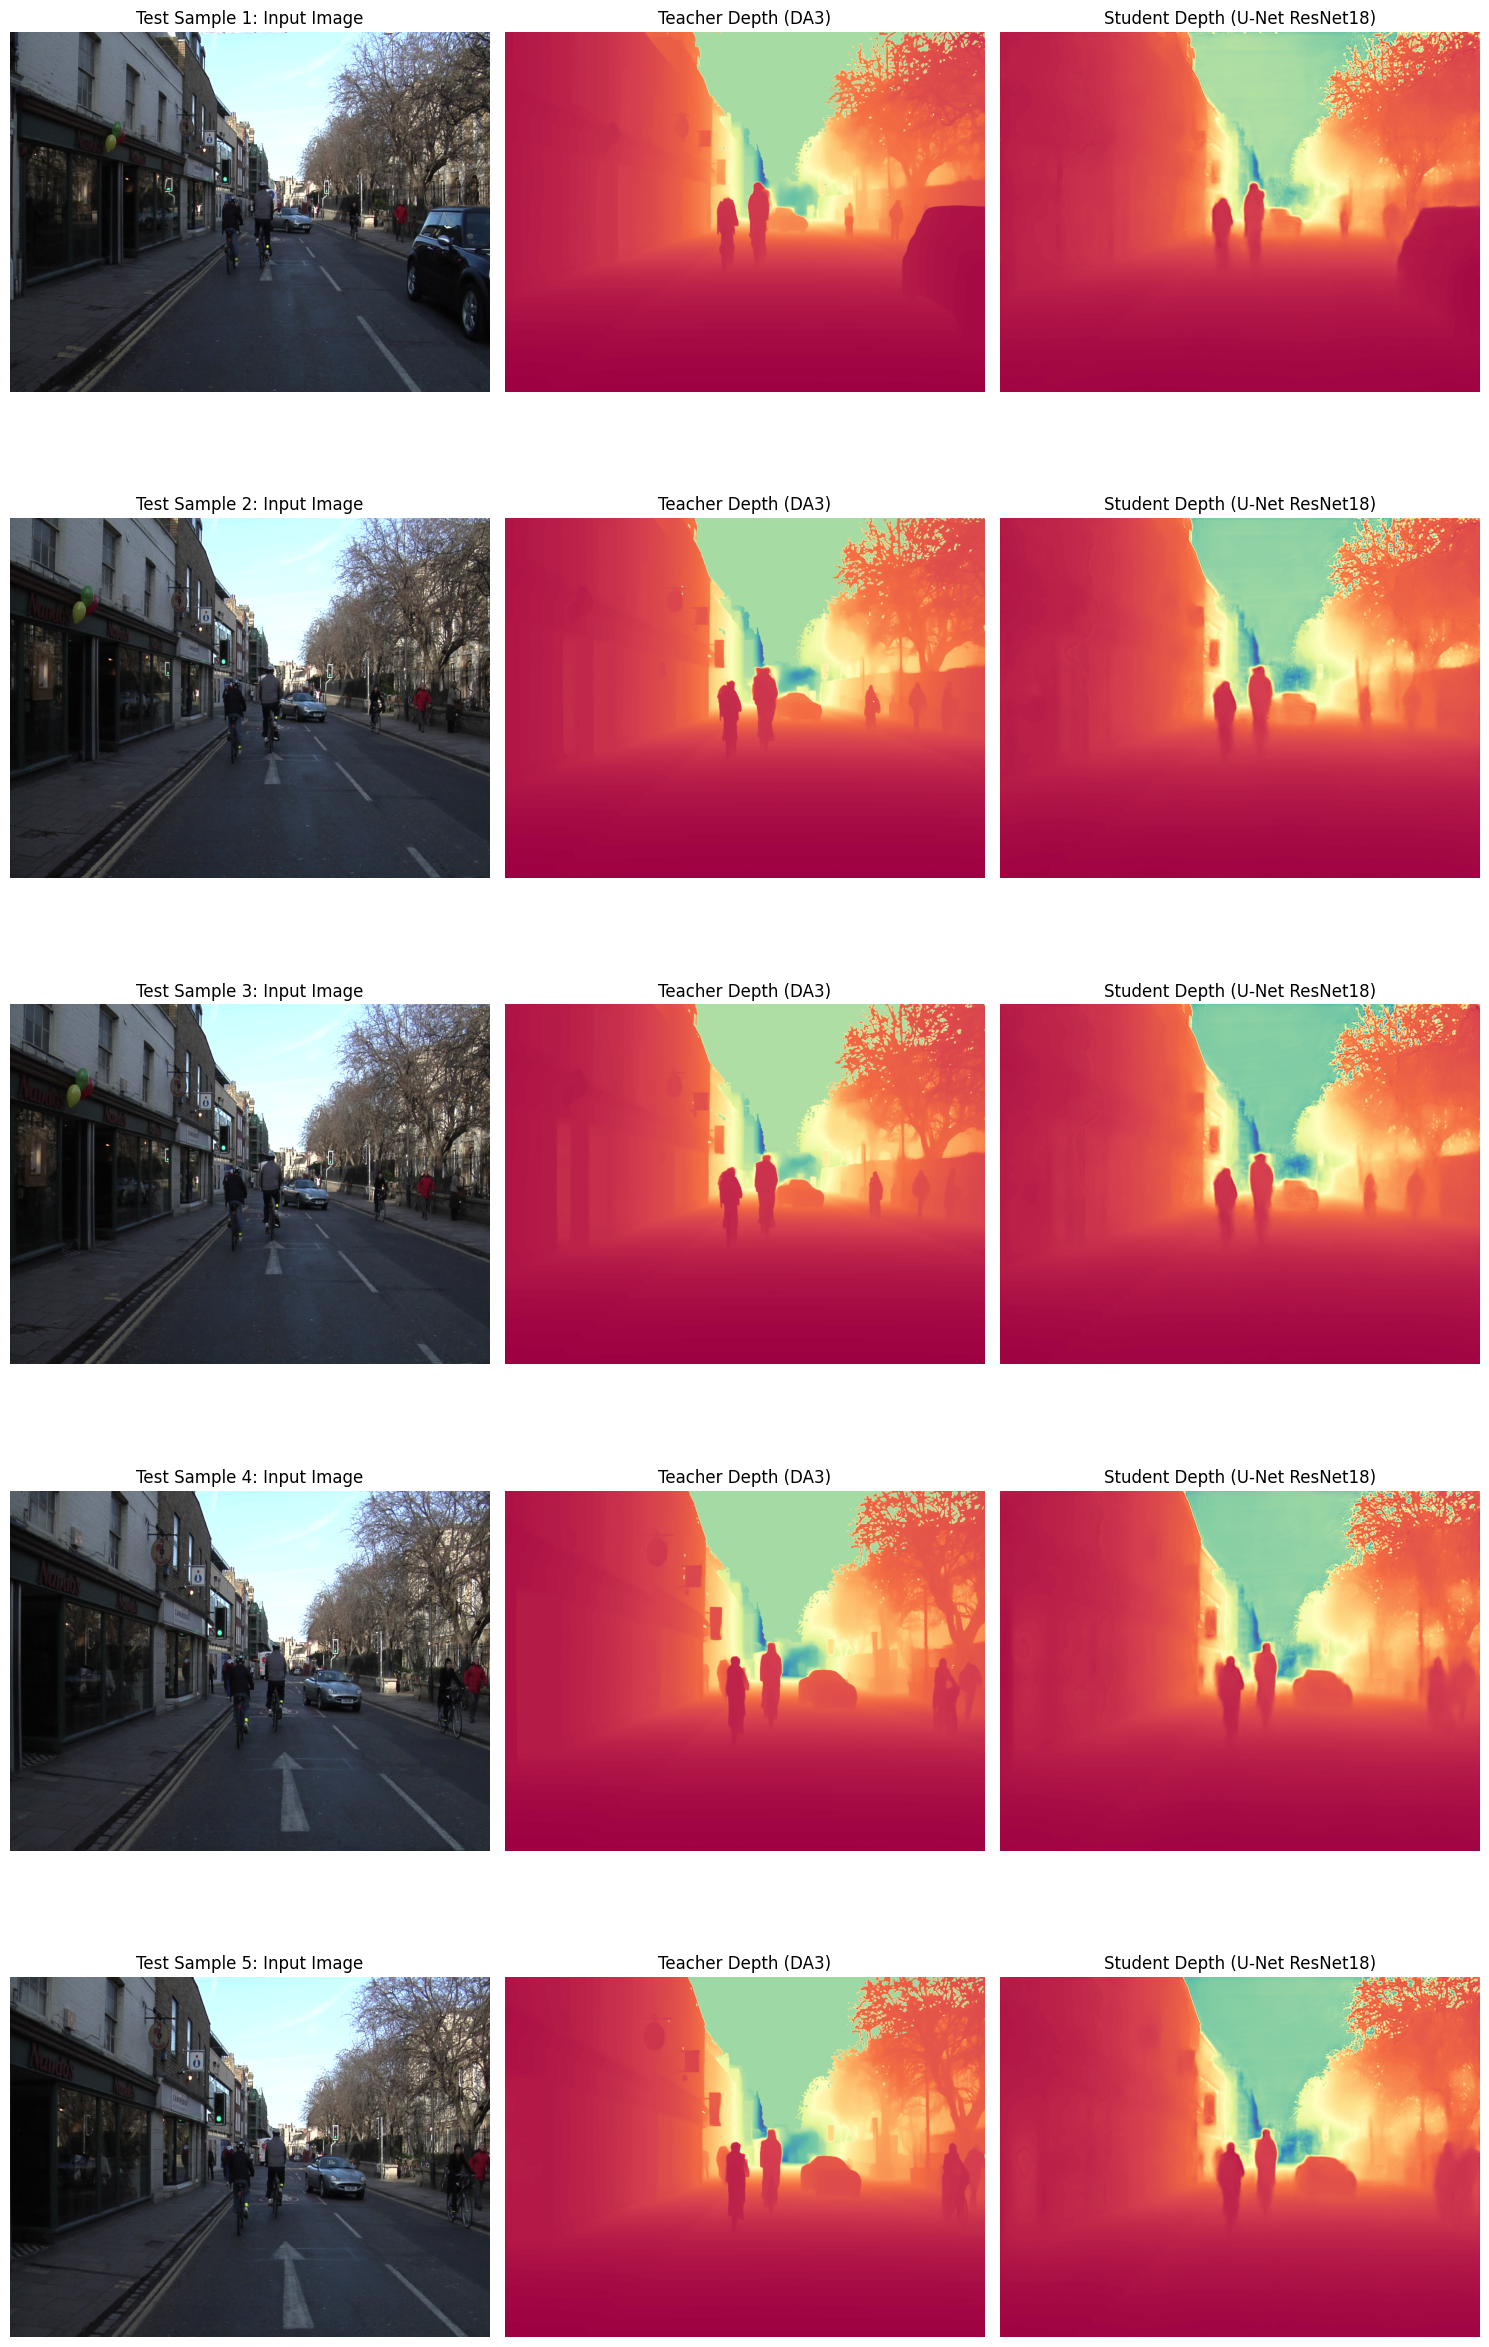

In [37]:
def visualize_predictions(model, dataset, num_samples=5, seed=42, title_prefix="Test"):
    """Visualize student predictions vs teacher depth maps"""
    
    model = model.to(device)
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))

    random.seed(seed)
    offset = random.randrange(0, len(dataset) - num_samples)
    
    with torch.no_grad():
        for i in range(min(num_samples, len(dataset))):
            image, teacher_depth = dataset[offset + i]
            
            # Get student prediction
            student_pred = model(image.unsqueeze(0).to(device))
            student_pred = student_pred.squeeze().cpu().numpy()
            
            # Denormalize image for visualization
            img_display = image.clone()
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            img_display = img_display * std + mean
            img_display = torch.clamp(img_display, 0, 1)
            
            # Plot
            axes[i, 0].imshow(img_display.permute(1, 2, 0))
            axes[i, 0].set_title(f'{title_prefix} Sample {i+1}: Input Image')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(teacher_depth.numpy(), cmap='Spectral')
            axes[i, 1].set_title('Teacher Depth (DA3)')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(student_pred, cmap='Spectral')
            axes[i, 2].set_title('Student Depth (U-Net ResNet18)')
            axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'{title_prefix.lower()}_depth_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()

print("Visualizing predictions on TEST set:")
test_dataset = DepthDistillationDataset(
    img_dir=TEST_IMG_DIR,
    depth_dir=TEST_DEPTH_DIR,
)
visualize_predictions(lightning_module.student, test_dataset, num_samples=5, title_prefix="Test")

## Calculate Metrics

In [25]:
def calculate_metrics(model, dataloader, split_name="Test"):
    """Calculate depth estimation metrics"""
    model.to(device)
    model.eval()
    
    total_mse = 0
    total_mae = 0
    total_abs_rel = 0
    num_samples = 0
    
    with torch.no_grad():
        for images, teacher_depth, _ in dataloader:
            images = images.to(device)
            teacher_depth = teacher_depth.to(device)
            
            # Get predictions
            student_pred = model(images).squeeze(1)
            
            # Calculate metrics
            mse = F.mse_loss(student_pred, teacher_depth)
            mae = F.l1_loss(student_pred, teacher_depth)
            
            # Absolute relative error
            abs_rel = torch.mean(torch.abs(student_pred - teacher_depth) / (teacher_depth + 1e-8))
            
            total_mse += mse.item() * images.size(0)
            total_mae += mae.item() * images.size(0)
            total_abs_rel += abs_rel.item() * images.size(0)
            num_samples += images.size(0)
    
    metrics = {
        'MSE': total_mse / num_samples,
        'MAE': total_mae / num_samples,
        'RMSE': np.sqrt(total_mse / num_samples),
        'Abs Rel': total_abs_rel / num_samples
    }
    
    print(f"\n{split_name} Set Metrics:")
    print("=" * 40)
    for metric_name, value in metrics.items():
        print(f"  {metric_name:12s}: {value:.4f}")
    print("=" * 40)
    
    return metrics

# Create data module
test_data_module = DataModule(
    train_img_dir=TRAIN_IMG_DIR,
    train_depth_dir=TRAIN_DEPTH_DIR,
    val_img_dir=VAL_IMG_DIR,
    val_depth_dir=VAL_DEPTH_DIR,
    test_img_dir=TEST_IMG_DIR,
    test_depth_dir=TEST_DEPTH_DIR,
    batch_size=best_params['batch_size'],
    num_workers=2,
    prob=None
)

# Calculate metrics on TEST set
test_loader = data_module.test_dataloader()
test_metrics = calculate_metrics(lightning_module.student, test_loader, split_name="Test")


Test Set Metrics:
  MSE         : 100.3521
  MAE         : 5.4747
  RMSE        : 10.0176
  Abs Rel     : 0.1252


## Test Set Detailed Analysis


Per-Sample Test Results:
--------------------------------------------------
Sample   0: MSE=208.9354, MAE=8.3587
Sample   1: MSE=218.3280, MAE=8.9052
Sample   2: MSE=146.5131, MAE=7.7367
Sample   3: MSE=135.6429, MAE=6.9726
Sample   4: MSE=209.8462, MAE=8.8324
Sample   5: MSE=195.0509, MAE=8.1908
Sample   6: MSE=233.6264, MAE=9.5490
Sample   7: MSE=175.9331, MAE=9.4260
Sample   8: MSE=242.4897, MAE=11.4496
Sample   9: MSE=147.9382, MAE=8.9224
Sample  10: MSE=152.6108, MAE=9.1468
Sample  11: MSE=148.9903, MAE=8.8256
Sample  12: MSE=201.0006, MAE=10.1470
Sample  13: MSE=124.3570, MAE=7.2710
Sample  14: MSE=112.2978, MAE=6.6815
Sample  15: MSE=108.8181, MAE=6.8455
Sample  16: MSE=159.2439, MAE=8.6396
Sample  17: MSE=230.3009, MAE=11.1691
Sample  18: MSE=274.8051, MAE=11.6435
Sample  19: MSE=262.9177, MAE=11.6585
Sample  20: MSE=237.4239, MAE=10.2594
Sample  21: MSE=235.8502, MAE=9.6017
Sample  22: MSE=195.9954, MAE=8.8421
Sample  23: MSE=380.8813, MAE=12.9329
Sample  24: MSE=226.6493, MA

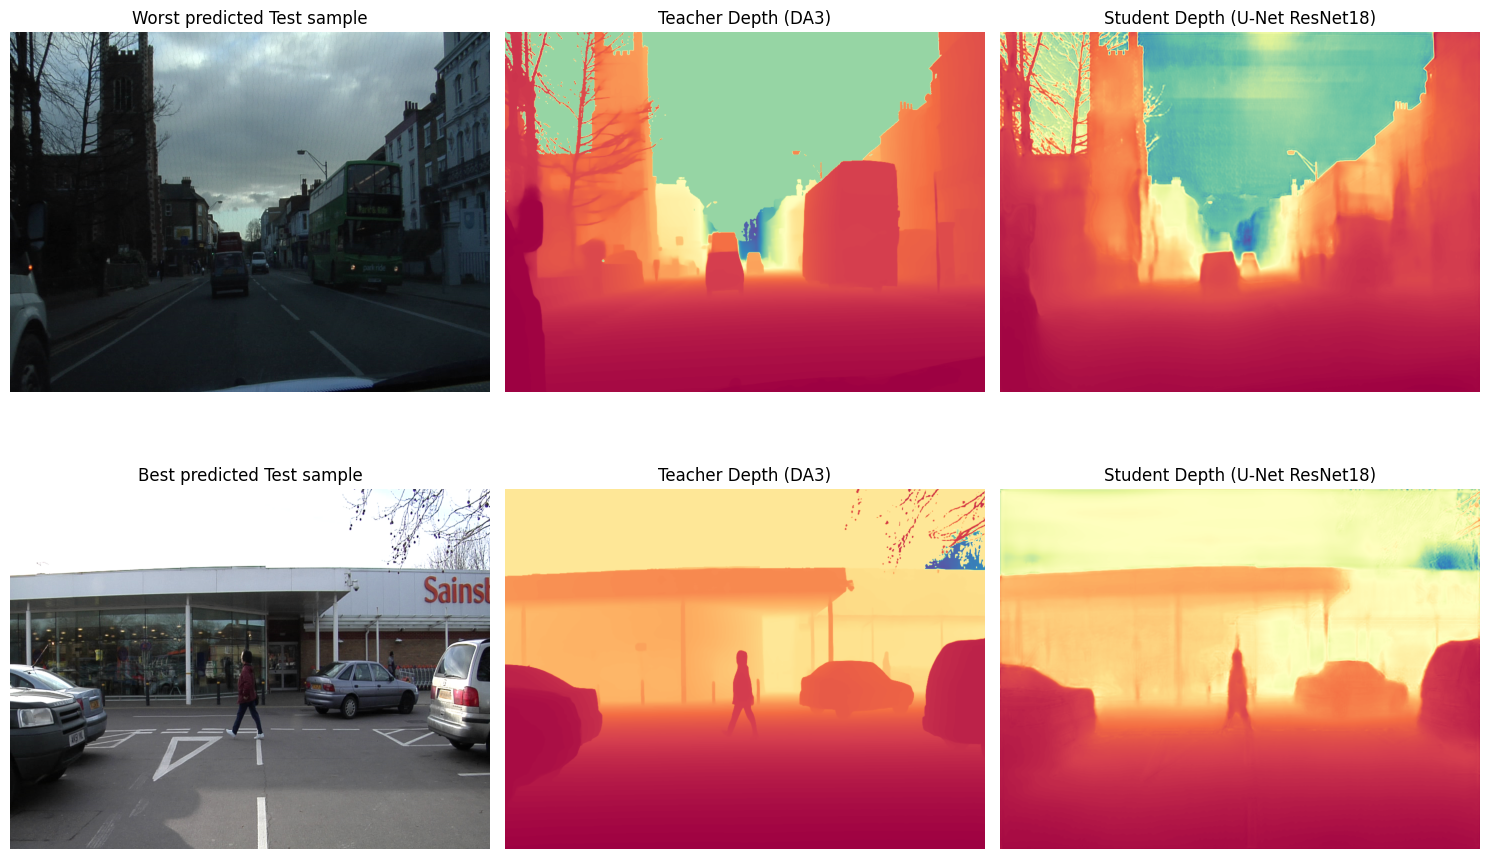

In [29]:
def detailed_test_analysis(model, dataset, num_samples=10):
    """Perform detailed analysis on test samples"""
    model.to(device)
    model.eval()
    
    errors = []

    worst_sample_idx = -1
    best_sample_idx = -1
    best_mse = np.inf
    worst_mse = 0
    
    with torch.no_grad():
        for i in range(min(num_samples, len(dataset))):
            image, teacher_depth = dataset[i]
            
            # Get prediction
            student_pred = model(image.unsqueeze(0).to(device))
            student_pred = student_pred.squeeze().cpu()
            
            # Calculate per-sample error
            mse = F.mse_loss(student_pred, teacher_depth).item()
            mae = F.l1_loss(student_pred, teacher_depth).item()
            
            errors.append({
                'sample_idx': i,
                'MSE': mse,
                'MAE': mae
            })

            # Track worst and best samples taking into account MSE value
            if mse > worst_mse:
                worst_mse = mse
                worst_sample_idx = i
                
            if mse < best_mse:
                best_mse = mse
                best_sample_idx = i
    
    # Print per-sample results
    print("\nPer-Sample Test Results:")
    print("-" * 50)
    for error in errors:
        print(f"Sample {error['sample_idx']:3d}: MSE={error['MSE']:.4f}, MAE={error['MAE']:.4f}")
    
    # Statistical summary
    mse_values = [e['MSE'] for e in errors]
    mae_values = [e['MAE'] for e in errors]
    
    print("\nStatistical Summary:")
    print("-" * 50)
    print(f"MSE - Mean: {np.mean(mse_values):.4f}, Std: {np.std(mse_values):.4f}")
    print(f"MAE - Mean: {np.mean(mae_values):.4f}, Std: {np.std(mae_values):.4f}")

    return worst_sample_idx, best_sample_idx

def visualize_edge_predictions(model, dataset, worst_sample_idx, best_sample_idx):
    """Visualize student predictions vs teacher depth maps"""
    
    model = model.to(device)
    model.eval()
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    with torch.no_grad():

        # Worst predicted sample
        image, teacher_depth = dataset[worst_sample_idx]
            
        # Get student prediction
        student_pred = model(image.unsqueeze(0).to(device))
        student_pred = student_pred.squeeze().cpu().numpy()
        
        # Denormalize image for visualization
        img_display = image.clone()
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img_display = img_display * std + mean
        img_display = torch.clamp(img_display, 0, 1)
        
        # Plot
        axes[0, 0].imshow(img_display.permute(1, 2, 0))
        axes[0, 0].set_title(f'Worst predicted Test sample')
        axes[0, 0].axis('off')
        
        axes[0, 1].imshow(teacher_depth.numpy(), cmap='Spectral')
        axes[0, 1].set_title('Teacher Depth (DA3)')
        axes[0, 1].axis('off')
        
        axes[0, 2].imshow(student_pred, cmap='Spectral')
        axes[0, 2].set_title('Student Depth (U-Net ResNet18)')
        axes[0, 2].axis('off')

        # Best predicted sample
        image, teacher_depth = dataset[best_sample_idx]
            
        # Get student prediction
        student_pred = model(image.unsqueeze(0).to(device))
        student_pred = student_pred.squeeze().cpu().numpy()
        
        # Denormalize image for visualization
        img_display = image.clone()
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img_display = img_display * std + mean
        img_display = torch.clamp(img_display, 0, 1)
        
        # Plot
        axes[1, 0].imshow(img_display.permute(1, 2, 0))
        axes[1, 0].set_title(f'Best predicted Test sample')
        axes[1, 0].axis('off')
        
        axes[1, 1].imshow(teacher_depth.numpy(), cmap='Spectral')
        axes[1, 1].set_title('Teacher Depth (DA3)')
        axes[1, 1].axis('off')
        
        axes[1, 2].imshow(student_pred, cmap='Spectral')
        axes[1, 2].set_title('Student Depth (U-Net ResNet18)')
        axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'worst_best_test_depth_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()

# Run detailed analysis
test_dataset = DepthDistillationDataset(
    img_dir=TEST_IMG_DIR,
    depth_dir=TEST_DEPTH_DIR,
)

worst_sample_idx, best_sample_idx = detailed_test_analysis(lightning_module.student, test_dataset, num_samples=len(test_dataset))
print(f"Worst predicted sample found at image #{worst_sample_idx}")
print(f"Best predicted sample found at image #{best_sample_idx}")
print()

visualize_edge_predictions(lightning_module.student, test_dataset, worst_sample_idx, best_sample_idx)